## DecisionTree

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import load

In [2]:
X_train, X_test, Y_train, Y_test = load('../../preprocessing/classification_data.joblib')

In [3]:
from sklearn.preprocessing import MinMaxScaler
feature_names = X_train.columns
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=feature_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

In [4]:
X_train.shape

(7500, 19)

In [5]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,0.750,0.283784,0.5,0.489974,0.000000,1.0,0.0,0.620117,0.25,0.730988,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.574,0.297297,0.9,0.647306,0.000000,1.0,1.0,0.626526,0.50,0.612940,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.906,0.432432,0.8,0.411821,0.000000,0.0,0.0,0.111890,1.00,0.593644,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.444,0.067568,0.2,0.532215,0.000000,0.0,1.0,0.334914,0.75,0.577753,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.568,0.459459,0.1,0.000000,0.333333,1.0,1.0,0.884548,0.75,0.918275,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


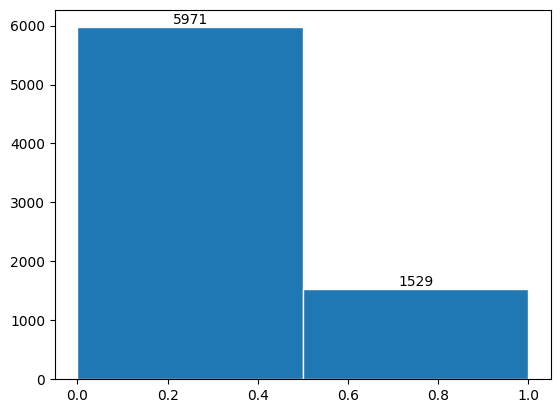

In [6]:
import numpy as np

freq, bins, _ = plt.hist(Y_train, edgecolor='white', bins=2)

bin_centers = np.diff(bins)*0.5 + bins[:-1] 

for fr, x in zip(freq, bin_centers):
    height = int(fr)
    plt.annotate("{}".format(height),
               xy = (x, height),             
               xytext = (0,0.2),             
               textcoords = "offset points", 
               ha = 'center', va = 'bottom'
               )

plt.show()

Vidimo da imamo nebalansiranost skupa podataka, zato cemo vise obracati paznju na f1 skor u odnosu na accuracy

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

dtc = DecisionTreeClassifier()

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from termcolor import colored

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['B', 'M'], index=['B', 'M']))
    print("---------------------------------------------------------------------------------")
    print('F1 score: ', f1_score(y, y_pred))
    print('Accuracy score: ', accuracy_score(y, y_pred))
    
    
def plot_decision_tree(model, feature_names):
    plt.figure(figsize=(7, 7))
    plot_tree(model, class_names=['B', 'M'], feature_names=feature_names, filled=True)
    plt.title("Decision tree of depth {} with {} nodes".format(model.get_depth(), model.get_n_leaves()))

    plt.show()
    print("---------------------------------------------------------------------------------")
    print(colored("Parameters of model {}".format(type(model).__name__), "green"))
    for k, v in model.get_params().items():
        print(colored(k, 'blue'), v)
    
    print("---------------------------------------------------------------------------------")


In [9]:
dtc.fit(X_train, Y_train) 

DecisionTreeClassifier()

In [10]:
report(dtc, X_train, Y_train)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5971
           1       1.00      1.00      1.00      1529

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
      B     M
B  5971     0
M     0  1529
---------------------------------------------------------------------------------
F1 score:  1.0
Accuracy score:  1.0


In [11]:
report(dtc, X_test,Y_test, "test")

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1991
           1       0.51      0.52      0.51       509

    accuracy                           0.80      2500
   macro avg       0.69      0.70      0.69      2500
weighted avg       0.80      0.80      0.80      2500

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on test data 
---------------------------------------------------------------------------------
      B    M
B  1731  260
M   243  266
---------------------------------------------------------------------------------
F1 score:  0.5140096618357488
Accuracy score:  0.7988


Vidimo da je doslo do preprligodjavanja modela, zato cemo da ogranicim maksimalnu dubinu stabla i da optimizujemo uz pomoc GridSearch-a.

## GridSearch

Posto su klase nebalansirane, modelu smo dodali vecinu tezinu za prvu klasu. Mozemo eksperimentisati sa parametrom tezine, pri cemu moramo voditi racuna da sva testiranja vrsimo na trening skupu.

In [12]:
from sklearn.model_selection import GridSearchCV

params = {'criterion': ['gini', 'entropy'],
          'max_depth': [2,4,6,8,10],
          'class_weight':[
              {1:1, 0:1},
              {1:2, 0:1},
              {1:3, 0:1}
          ]
         }

estimator = GridSearchCV(DecisionTreeClassifier(random_state=55), param_grid=params, cv=3, scoring='f1')
estimator.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=55),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10]},
             scoring='f1')

In [13]:
estimator.best_params_

{'class_weight': {1: 2, 0: 1}, 'criterion': 'gini', 'max_depth': 6}

In [14]:
report(estimator.best_estimator_, X_test, Y_test, 'test')
best_dtc = estimator.best_estimator_

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1991
           1       0.62      0.57      0.59       509

    accuracy                           0.84      2500
   macro avg       0.76      0.74      0.75      2500
weighted avg       0.84      0.84      0.84      2500

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on test data 
---------------------------------------------------------------------------------
      B    M
B  1812  179
M   219  290
---------------------------------------------------------------------------------
F1 score:  0.5930470347648262
Accuracy score:  0.8408


Mozemo primetita da su nam se povecali kako f1 skor, tako i preciznost modela.

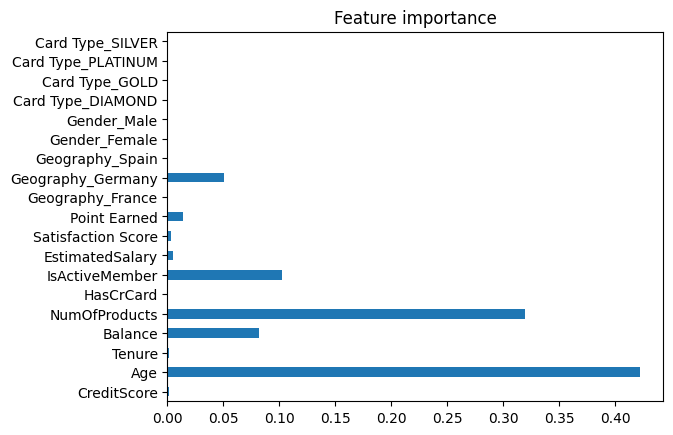

In [16]:
pd.Series(best_dtc.feature_importances_, index=X_train.columns).plot.barh()
plt.title("Feature importance")
plt.show()

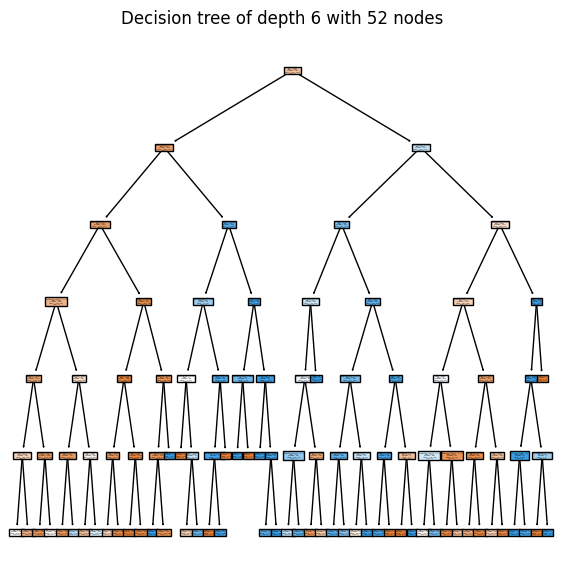

---------------------------------------------------------------------------------
Parameters of model DecisionTreeClassifier
ccp_alpha 0.0
class_weight {1: 2, 0: 1}
criterion gini
max_depth 6
max_features None
max_leaf_nodes None
min_impurity_decrease 0.0
min_samples_leaf 1
min_samples_split 2
min_weight_fraction_leaf 0.0
random_state 55
splitter best
---------------------------------------------------------------------------------


In [17]:
plot_decision_tree(best_dtc, list(X_train.columns))

### RandomForest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier()

In [17]:
report(rf, X_test, Y_test, 'test')

Classification report for model RandomForestClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1991
           1       0.79      0.46      0.58       509

    accuracy                           0.87      2500
   macro avg       0.83      0.72      0.75      2500
weighted avg       0.86      0.87      0.85      2500

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on test data 
---------------------------------------------------------------------------------
      B    M
B  1928   63
M   274  235
---------------------------------------------------------------------------------
F1 score:  0.5824039653035936
Accuracy score:  0.8652


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {'max_depth': [2,4,6,8,10],
              'criterion': ['entropy', 'gini', 'log_loss'],
              'n_estimators': [50, 100, 200, 300]
             }

model = RandomForestClassifier(class_weight={1:2,0:1})
gridRandomForest = RandomizedSearchCV(model, parameters, cv = 5, n_jobs = -1, random_state=41)
gridRandomForest.fit(X_train, Y_train)

gridRandomForest.best_params_

{'n_estimators': 300, 'max_depth': 10, 'criterion': 'log_loss'}

In [19]:
best_rf = gridRandomForest.best_estimator_

In [20]:
report(best_rf, X_test, Y_test, 'test')

Classification report for model RandomForestClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1991
           1       0.72      0.53      0.61       509

    accuracy                           0.86      2500
   macro avg       0.80      0.74      0.76      2500
weighted avg       0.85      0.86      0.85      2500

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on test data 
---------------------------------------------------------------------------------
      B    M
B  1886  105
M   240  269
---------------------------------------------------------------------------------
F1 score:  0.609286523216308
Accuracy score:  0.862


Probacemo da izvrsimo balansiranje klasa nekom od tehnika i da ponovo pokrenemo poslednji RandomizedSearch na RandomForest-u.

In [23]:
from collections import Counter

def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled

In [24]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=10, random_state=42)

X_resampled, y_resampled = resample(smote, X_train, Y_train)

Number of instances before resampling with SMOTE : dict_items([(0, 5971), (1, 1529)]). 
Number of instances after  resampling with SMOTE : dict_items([(0, 5971), (1, 5971)]). 


In [25]:
gridRandomForest_resampled = RandomizedSearchCV(RandomForestClassifier(), parameters, cv = 5, n_jobs = -1, random_state=41)
gridRandomForest_resampled.fit(X_resampled, y_resampled)

best_rf_resampled = gridRandomForest_resampled.best_estimator_
gridRandomForest_resampled.best_params_

{'n_estimators': 300, 'max_depth': 10, 'criterion': 'log_loss'}

In [26]:
report(best_rf_resampled, X_test, Y_test)

Classification report for model RandomForestClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1991
           1       0.58      0.66      0.62       509

    accuracy                           0.83      2500
   macro avg       0.75      0.77      0.76      2500
weighted avg       0.84      0.83      0.84      2500

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on training data 
---------------------------------------------------------------------------------
      B    M
B  1747  244
M   172  337
---------------------------------------------------------------------------------
F1 score:  0.618348623853211
Accuracy score:  0.8336


Mozemo primetiti da nam je se povecao recall na ustrb preciznosti i da su rezulati priblizno isti.

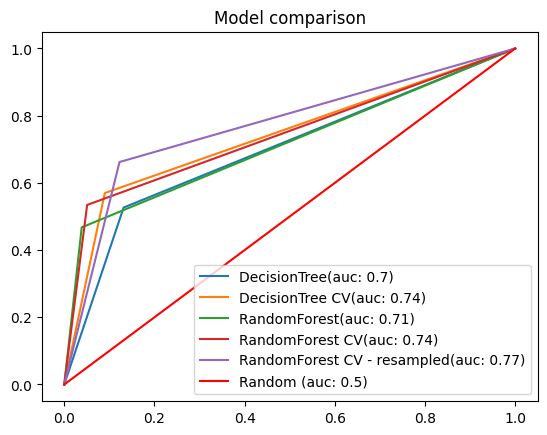

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [dtc, best_dtc, rf, best_rf,  best_rf_resampled]
model_names = ['DecisionTree', 'DecisionTree CV',  'RandomForest', 'RandomForest CV', 'RandomForest CV - resampled']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Model comparison")
plt.legend()
plt.show()

Odavde mozemo da vidimo da najbolje rezultate pokazuje RandomForest nakon resample-ovanja.